In [1]:
import json
import pandas as pd
import numpy as np
import math
from statistics import NormalDist

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format

### SETUP 

In [2]:
def param_default():
    return {
        'dataset' : 'code_completion_random_cut_5k_30_512_tokens',
        #'dataset' : 'code_completion_docstring_random_cut_3.8k_30_150_tokens',
        #'dataset' : 'code_completion_docstring_signature_3.8k_30_150_tokens',
        #'dataset' : 'code_completion_docstring_5k_30_150_tokens',
        'global_ast_results': '/workspaces/code-rationales/data/global_ast_results/gpt',
        'global_taxonomy_results': '/workspaces/code-rationales/data/global_taxonomy_results/gpt',
        'num_experiments' : 30, 
        'bootstrapping': 500
    }
params = param_default()

### Taxonomy Classification

In [3]:
def global_groups() -> dict:
    return {
        'sc_semantic': ['exceptions', 'oop', 'asserts', 'types', 'conditionals', 'loops', 'bool', 'structural', 'statements', 'with'], 
        'sc_nl': ['identifier', 'comment', 'string'],
        'sc_not_semantic': ['punctuation', 'operators', 'indentation', 'functional', 'return', 'expression', 'unknown'], 
        'sc_errors' : ['errors'], 
        'nl_semantic': ['nl_verb', 'nl_noun', 'nl_pronoun', 'nl_adjetive'],
        'nl_not_semantic' : ['nl_adverb', 'nl_determier', 'nl_preposition', 'nl_particle', 'nl_modal', 'nl_conjunction', 'nl_cardinal', 'nl_list', 'nl_other']
    }

### Load Aggregation results

In [4]:
get_experiment_path =  lambda results_folder, dataset, exp: results_folder + '/' + dataset + '_exp_' + str(exp) +'.txt'


In [5]:
def get_experiments_results(results_folder):
    experiment_paths = [get_experiment_path(results_folder, params['dataset'], exp) for exp in range(params['num_experiments'])]
    experiment_global_results = []
    for experiment_path in experiment_paths:
        with open(experiment_path, 'r') as file:
            experiment_global_results.append(json.loads(file.read()))
    return experiment_global_results


### Dictionary Flatting

In [6]:
def flat_global_results(experiment_global_result: dict):
    flatten_results = { key: [] for key in experiment_global_result.keys() }
    for target_key, rationales in experiment_global_result.items():
        for rational_key, rational_values in rationales.items():
            flatten_results[rational_key] += rational_values
    return flatten_results

### Statistics

In [7]:
def bootstrapping( np_data, np_func, size ):
    """Create a bootstrap sample given data and a function
    For instance, a bootstrap sample of means, or mediands. 
    The bootstrap replicates are a long as the original size
    we can choose any observation more than once (resampling with replacement:np.random.choice)
    """
    
    #Cleaning NaNs
    #np_data_clean = np_data[ np.logical_not( np.isnan(np_data) ) ] 
    
    #The size of the bootstrap replicate is as big as size
    #Creating the boostrap replicates as long as the orignal data size
    #This strategy might work as imputation 
    bootstrap_repl = [ np_func( np.random.choice( np_data, size=len(np_data) ) ) for i in range( size ) ]
    
    #logging.info("Covariate: " + cov) #Empirical Mean
    #logging.info("Empirical Mean: " + str(np.mean(np_data_clean))) #Empirical Mean
    #logging.info("Bootstrapped Mean: " + str( np.mean(bootstrap_repl) ) ) #Bootstrapped Mean
    
    return np.array( bootstrap_repl )

In [8]:
def confidence_intervals_large_samples(data, confidence=0.95):
    """
    @confidence: confidence interval 
    @return: tuple (lowerbound, uperbound, h-value)
    """
    dist = NormalDist.from_samples( data )
    z = NormalDist().inv_cdf((1 + confidence) / 2.)
    h = dist.stdev * z / ((len(data) - 1) ** .5)
    return dist.mean - h, dist.mean + h, h

In [9]:
def boostrap_dictionary(dictionary: dict, size):
    boostrapped_dict = {}
    for key, values in dictionary.items():
        if values:
            boostrapped_dict[key] = bootstrapping(values, np.mean, size).tolist()
    return boostrapped_dict

### Data processing

In [10]:
def get_experiments_dfs(experients_global_results):
    experiment_dfs = []
    for experiment in experients_global_results:
        experiment = flat_global_results(experiment)
        experiment = boostrap_dictionary(experiment, params['bootstrapping'])
        experiment_dfs.append(pd.DataFrame(experiment))
    return experiment_dfs

In [11]:
def reduce_rationales_df(experients_global_results: dict, target_list: list, rational_list: list):
    rationales_df = {target: {rational: [] for rational in rational_list} for target in target_list}
    for experient_global_result in experients_global_results:
        target_dictionary = {key: value for key, value in experient_global_result.items() if key in target_list}
        for target_key in target_dictionary.keys():
            target_dictionary[target_key] = {key: np.median(bootstrapping(value, np.mean, params['bootstrapping'])) # MEDIAN FOR EXPERIMENT RESULT
                                             for key, value in target_dictionary[target_key].items() if key in rational_list}
            for rational_key in target_dictionary[target_key].keys():
                rationales_df[target_key][rational_key].append(target_dictionary[target_key][rational_key])
    for target_key in rationales_df.keys():
        rationales_df[target_key] = boostrap_dictionary(rationales_df[target_key], params['bootstrapping'])
    return rationales_df         

In [12]:
def print_heatmap(
        experients_global_results: dict, 
        target_list: list, 
        rational_list: list,
        fig_size = (10,10), 
        font = 15
):
        reduced_rationales_global_results_df = pd.DataFrame(reduce_rationales_df(experients_global_results, target_list, rational_list)).fillna(0)
        for column in reduced_rationales_global_results_df.columns:
                reduced_rationales_global_results_df[column] = reduced_rationales_global_results_df[column].apply(lambda value: np.median(value)) 

        plt.rcParams.update({'font.size': font})
        ax = plt.axes()
        sns.set(rc = {'figure.figsize':fig_size})
        sns.heatmap(reduced_rationales_global_results_df, cmap="YlGnBu", ax=ax)
        plt.show
        pass

### Analysis - Rational Concept - Countings

In [13]:
def create_frequencies_dataframe(experients_global_results: list):
    frequencies_df = pd.DataFrame(columns=experients_global_results[0].keys())
    for experiment_global_result in experients_global_results:
        rationales_results = flat_global_results(experiment_global_result)
        frequencies_df = frequencies_df.append({key: len(value) for key, value in rationales_results.items()}, ignore_index=True)
    frequencies_df = frequencies_df.fillna(0)   
    return frequencies_df


### Analysis - Rational Concept - Bootstrapping

In [14]:
def create_bootstapped_dataframe(experients_global_results:list):
    bootstrapped_df = pd.DataFrame(columns=experients_global_results[0].keys())
    for experiment_global_result in experients_global_results:
        rationales_results = flat_global_results(experiment_global_result)
        rationales_results = boostrap_dictionary(rationales_results, params['bootstrapping'])
        bootstrapped_df = bootstrapped_df.append({key: np.median(value) for key, value in rationales_results.items()}, ignore_index=True) #MEDIAN FOR EXPERIMENTS
    bootstrapped_df = bootstrapped_df.fillna(0)
    return bootstrapped_df

### Calculate statistics and get results DF

In [15]:
### CREATE GROUP FREQUENCY RESULTS
def calculate_results(global_dataframe):
    results_df = pd.DataFrame(columns=['type', 'group', 'category', 'mean', 'median', 'std', 'ci'])
    for category in global_dataframe.columns:
        experiments_values = global_dataframe[category].tolist()
        try:
            group = [key for key, value in global_groups().items() if category in value][0]
        except Exception as e:
            print(e)
        results_df = results_df.append({
            'type': group.split('_')[0], 
            'group': group, 
            'category': category, 
            'median' : np.median(experiments_values),
            'mean' : np.mean(experiments_values), 
            'std' : np.std(experiments_values),
            'ci' : confidence_intervals_large_samples(experiments_values), 
            'exp_values':experiments_values
        }, ignore_index=True)
    return results_df.sort_values(by='median', ascending=False).reset_index(drop=True)

### Execute Frequency Analysis

In [16]:
experients_global_results = get_experiments_results(params['global_taxonomy_results'])
global_frequencies_dataframe = create_frequencies_dataframe(experients_global_results)

In [23]:
global_frequencies_dataframe

punctuation    oop  asserts    types  conditionals  loops  operators  \
0      37258.00 773.00   126.00  8812.00        434.00 329.00    5999.00   
1      37995.00 724.00   137.00 12372.00        471.00 273.00    6446.00   
2      36478.00 922.00   145.00 10036.00        296.00 270.00    4811.00   
3      36557.00 727.00   163.00  6819.00        481.00 408.00    5374.00   
4      34314.00 697.00   147.00  7016.00        404.00 229.00    4454.00   
5      36948.00 751.00   121.00  8968.00        296.00 239.00    6080.00   
6      36788.00 719.00   158.00 10828.00        428.00 170.00    6230.00   
7      36322.00 673.00   225.00  6329.00        429.00 257.00    4879.00   
8      37907.00 828.00   141.00  6482.00        382.00 320.00    5103.00   
9      35583.00 731.00   116.00  8500.00        179.00 146.00    5417.00   
10     36122.00 866.00   167.00  6847.00        323.00 303.00    4764.00   
11     35685.00 579.00   207.00 10880.00        306.00 227.00    4694.00   
12     38296.00 648.00   162.00  8322.00        342.00 405.00    5227.00   
13     37319.00 610.00   140.00  9755.00        269.00 262.00    6905.00   
14     37112.00 659.00   156.00  6782.00        286.00 290.00    5917.00   
15     37244.00 696.00   156.00  5826.00        328.00 256.00    4480.00   
16     37947.00 645.00   194.00 10624.00        203.00 242.00    5616.00   
17     34624.00 574.00   139.00  6804.00        261.00 256.00    4259.00   
18     34950.00 814.00   323.00  6760.00        329.00 200.00    4474.00   
19     36340.00 716.00   162.00  5824.00        188.00 223.00    4266.00   
20     35761.00 420.00   146.00  8356.00        254.00 132.00    4712.00   
21     37269.00 639.00   146.00  8965.00        378.00 230.00    5052.00   
22     38870.00 800.00   176.00  9799.00        374.00 248.00    6298.00   
23     36039.00 583.00   148.00 11805.00        248.00 527.00    4895.00   
24     36325.00 616.00   150.00  9539.00        272.00 191.00    5718.00   
25     35132.00 692.00   128.00  5578.00        258.00 260.00    4588.00   
26     35967.00 777.00   173.00  8725.00        216.00 267.00    5252.00   
27     36302.00 617.00   162.00  7982.00        425.00 277.00    5688.00   
28     37210.00 739.00   138.00  9971.00        303.00 237.00    6055.00   
29     36324.00 695.00   203.00  7265.00        480.00 169.00    6567.00   

     bool  functional     with  ...  nl_adverb  nl_adjetive  nl_determier  \
0  286.00      315.00  6998.00  ...     700.00      1347.00        756.00   
1  109.00      298.00  5306.00  ...     379.00      2061.00        354.00   
2   98.00      632.00  5277.00  ...     628.00      1331.00        786.00   
3  122.00      525.00  5102.00  ...     619.00      1464.00        644.00   
4   96.00      355.00  3350.00  ...     623.00       872.00        505.00   
5  128.00      258.00  6810.00  ...     695.00      1547.00        785.00   
6  129.00      326.00  4452.00  ...     469.00      2006.00        584.00   
7   38.00      256.00  4353.00  ...     640.00      2100.00        475.00   
8  160.00      436.00  4427.00  ...     677.00      1507.00        438.00   
9  106.00      168.00  6316.00  ...     563.00      1781.00        803.00   
10 226.00      238.00  6022.00  ...     809.00      2402.00        762.00   
11 218.00      343.00  5302.00  ...     897.00      1652.00        688.00   
12  79.00      577.00 10409.00  ...     464.00      1926.00        616.00   
13 118.00      230.00  4179.00  ...     755.00      1334.00        908.00   
14 129.00      165.00  5956.00  ...     948.00      1844.00        580.00   
15  92.00      382.00  6058.00  ...     616.00      1980.00        640.00   
16  80.00      418.00  7195.00  ...     749.00      1071.00        801.00   
17  54.00      278.00  6421.00  ...     528.00      1127.00        525.00   
18  71.00      249.00  6040.00  ...     932.00       933.00        387.00   
19  66.00      204.00  5316.00  ...     680.00      2488.00        492.00   
20  83.00      326.00  4566.00

In [22]:
experients_global_results[0]

{'punctuation': {'punctuation': [0.08497896045446396,
   0.03983690217137337,
   0.02251134254038334,
   0.2888197898864746,
   0.39246025681495667,
   0.20833441615104675,
   0.14429713785648346,
   0.19749021530151367,
   0.13243600726127625,
   0.08230219036340714,
   0.16242994368076324,
   0.15711967647075653,
   0.04099592939019203,
   0.21021509170532227,
   0.2945118546485901,
   0.19327032566070557,
   0.16303397715091705,
   0.13641555607318878,
   0.0948251262307167,
   0.10518728941679001,
   0.10525643080472946,
   0.06206756830215454,
   0.05818471685051918,
   0.14903482794761658,
   0.19483420252799988,
   0.02079545520246029,
   0.035910408943891525,
   0.09057172387838364,
   0.14464329183101654,
   0.2730296552181244,
   0.09595584124326706,
   0.2766387164592743,
   0.12219840288162231,
   0.16991043090820312,
   0.02830609306693077,
   0.32148489356040955,
   0.2730296552181244,
   0.19150154292583466,
   0.12379053980112076,
   0.2321833223104477,
   0.18586087226

In [17]:
calculate_results(global_frequencies_dataframe)

type            group        category      mean    median      std  \
0    sc        sc_errors          errors 179914.33 179867.00  6623.77   
1    sc  sc_not_semantic         unknown 165232.73 165521.50  5660.64   
2    sc  sc_not_semantic      expression 117287.03 114360.50 22630.59   
3    sc            sc_nl      identifier  69317.20  69290.00  2107.57   
4    sc      sc_semantic      structural  69068.33  68666.50  4086.34   
5    nl      nl_semantic         nl_noun  68193.70  67616.50  2174.67   
6    sc  sc_not_semantic     punctuation  36566.27  36409.00  1064.52   
7    sc      sc_semantic      statements  26452.03  26832.50  4754.09   
8    sc      sc_semantic           types   8419.03   8428.00  1833.57   
9    sc            sc_nl          string   6743.80   6815.00   833.60   
10   sc      sc_semantic            with   5725.83   5542.50  1375.35   
11   sc  sc_not_semantic       operators   5340.67   5239.50   735.23   
12   nl      nl_semantic         nl_verb   3799.10   3798.50   399.47   
13   sc            sc_nl         comment   3480.27   3416.50   757.28   
14   nl      nl_semantic     nl_adjetive   1658.40   1665.50   436.46   
15   sc  sc_not_semantic          return   1663.90   1654.00   107.64   
16   sc      sc_semantic             oop    697.67    696.50    98.48   
17   nl  nl_not_semantic       nl_adverb    714.10    681.50   190.30   
18   nl  nl_not_semantic    nl_determier    626.27    628.00   163.94   
19   nl  nl_not_semantic  nl_preposition    566.17    545.00   160.73   
20   nl  nl_not_semantic        nl_other    378.67    374.50   113.99   
21   sc  sc_not_semantic      functional    379.20    326.00   202.78   
22   sc      sc_semantic    conditionals    328.10    314.50    86.43   
23   sc      sc_semantic           loops    261.43    256.00    78.70   
24   nl  nl_not_semantic     nl_cardinal    201.63    158.00   167.63   
25   sc      sc_semantic         asserts    161.83    153.00    38.87   
26   sc      sc_semantic            bool    112.00    103.50    53.56   
27   nl  nl_not_semantic        nl_modal     51.93     45.00    51.95   
28   nl      nl_semantic      nl_pronoun     65.70     43.00    65.41   
29   nl  nl_not_semantic  nl_conjunction     36.70     31.50    34.56   
30   sc      sc_semantic      exceptions     42.80     16.00    52.28   
31   nl  nl_not_semantic     nl_particle      3.40      0.00     8.16   

                                                   ci  \
0   (177462.35905934658, 182366.3076073201, 2451.9...   
1   (163137.29015337466, 167328.176513292, 2095.44...   
2   (108909.6833228153, 125664.38334385138, 8377.3...   
3   (68537.02415537018, 70097.37584462982, 780.175...   
4   (67555.6615328142, 70581.00513385245, 1512.671...   
5   (67388.68597421749, 68998.71402578251, 805.014...   
6   (36172.203883291535, 36960.329450041805, 394.0...   
7   (24692.17208099689, 28211.894585669776, 1759.8...   
8   (7740.2863122416, 9097.780354425066, 678.74702...   
9   (6435.219166864138, 7052.380833135862, 308.580...   
10  (5216.708690188423, 6234.957976478243, 509.124...   
11  (5068.50220008528, 5612.831133248054, 272.1644...   
12  (3651.223437137652, 3946.9765628623477, 147.87...   
13  (3199.939532905664, 3760.59380042767, 280.3271...   
14  (1496.8319928010674, 1819.9680071989328, 161.5...   
15  (1624.0538224263444, 1703.7461775736558, 39.84...   
16  (661.2118185315122, 734.121514801821, 36.45484...   
17  (643.6569233928365, 784.5430766071636, 70.4430...   
18  (565.5798137287385, 686.9535196045948, 60.6868...   
19  (506.66885521518424, 625.6644781181491, 59.497...   
20  (336.4690333998361, 420.86429993349725, 42.197...   
21  (304.1364733223961, 454.26352667760386, 75.063...   
22  (296.105053436197, 360.09494656380303, 31.9949...   
23  (232.3013622423252, 290.56530442434143, 29.131...   
24  (139.57955202399071, 263.6871146426759, 62.053...   
25  (147.44548529336717, 176.22118137329952, 14.38...   
26  (92.17328499338453, 131.82671500661547, 19.826... 

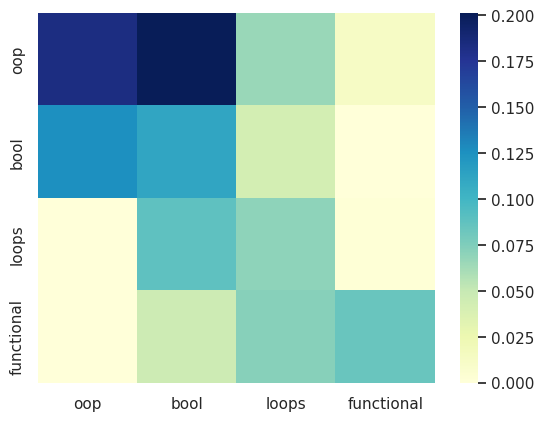

In [18]:
target_list = ['oop', 'bool', 'loops', 'functional']
source_list = ['oop', 'bool', 'loops', 'functional']
print_heatmap(experients_global_results, target_list, source_list)

### Execute Rationales Analysis

In [19]:
experients_global_results = get_experiments_results(params['global_taxonomy_results'])
global_frequencies_dataframe = create_frequencies_dataframe(experients_global_results)
global_bootstrapped_dataframe = create_bootstapped_dataframe(experients_global_results)

In [20]:
calculate_results(global_bootstrapped_dataframe)

type            group        category  mean  median  std  \
0    sc      sc_semantic             oop  0.10    0.10 0.02   
1    sc      sc_semantic            bool  0.10    0.10 0.03   
2    sc      sc_semantic           loops  0.09    0.09 0.02   
3    sc  sc_not_semantic      functional  0.08    0.08 0.02   
4    sc      sc_semantic      exceptions  0.11    0.07 0.13   
5    sc      sc_semantic    conditionals  0.07    0.07 0.01   
6    sc  sc_not_semantic       operators  0.07    0.07 0.01   
7    nl      nl_semantic         nl_noun  0.07    0.07 0.00   
8    sc            sc_nl      identifier  0.06    0.07 0.00   
9    sc  sc_not_semantic         unknown  0.06    0.06 0.00   
10   sc  sc_not_semantic          return  0.06    0.06 0.00   
11   sc      sc_semantic      structural  0.06    0.06 0.00   
12   sc      sc_semantic      statements  0.07    0.06 0.01   
13   sc      sc_semantic            with  0.06    0.06 0.01   
14   sc        sc_errors          errors  0.06    0.06 0.00   
15   sc      sc_semantic           types  0.06    0.06 0.01   
16   sc  sc_not_semantic      expression  0.06    0.06 0.00   
17   sc            sc_nl         comment  0.06    0.06 0.01   
18   sc  sc_not_semantic     punctuation  0.06    0.06 0.00   
19   nl  nl_not_semantic       nl_adverb  0.05    0.05 0.01   
20   nl      nl_semantic         nl_verb  0.05    0.05 0.01   
21   nl      nl_semantic     nl_adjetive  0.05    0.05 0.01   
22   sc            sc_nl          string  0.05    0.05 0.01   
23   nl  nl_not_semantic     nl_cardinal  0.06    0.05 0.03   
24   nl  nl_not_semantic        nl_modal  0.06    0.05 0.04   
25   nl  nl_not_semantic  nl_preposition  0.05    0.05 0.01   
26   nl  nl_not_semantic        nl_other  0.04    0.04 0.01   
27   nl  nl_not_semantic    nl_determier  0.04    0.04 0.01   
28   sc      sc_semantic         asserts  0.04    0.03 0.01   
29   nl      nl_semantic      nl_pronoun  0.04    0.03 0.04   
30   nl  nl_not_semantic  nl_conjunction  0.02    0.02 0.02   
31   nl  nl_not_semantic     nl_particle  0.00    0.00 0.01   

                                                   ci  \
0   (0.09826887056101977, 0.10979127601284669, 0.0...   
1   (0.08792844911864112, 0.11266371596551458, 0.0...   
2   (0.08670232467902053, 0.0979701884704631, 0.00...   
3   (0.0766782850598272, 0.091529137374103, 0.0074...   
4   (0.061674151301426415, 0.15730770552373963, 0....   
5   (0.06561906418205898, 0.0750021740795255, 0.00...   
6   (0.06436381841119915, 0.06838801162801597, 0.0...   
7   (0.06454149449904116, 0.0660813747210396, 0.00...   
8   (0.06398458873094302, 0.06559641816693977, 0.0...   
9   (0.06421466270806266, 0.06571521591687875, 0.0...   
10  (0.06305149237578524, 0.06586969648939893, 0.0...   
11  (0.06337652658465012, 0.06503950295006405, 0.0...   
12  (0.06406941290257748, 0.0682262803048454, 0.00...   
13  (0.058437283364863306, 0.06599647744162064, 0....   
14  (0.06196829680237884, 0.06366539199372222, 0.0...   
15  (0.05993453083384343, 0.06377572595156815, 0.0...   
16  (0.05913239076543845, 0.060960606003901845, 0....   
17  (0.05661151845256621, 0.06746467158145791, 0.0...   
18  (0.057180642187001994, 0.058404792295924636, 0...   
19  (0.05092168911458208, 0.05730682540673939, 0.0...   
20  (0.05062023585456627, 0.054411718315962455, 0....   
21  (0.04875387488896761, 0.057775262863559704, 0....   
22  (0.049375045929037326, 0.05362740357135015, 0....   
23  (0.04401992623723144, 0.06936327963908293, 0.0...   
24  (0.04023150078014395, 0.07269903679512901, 0.0...   
25  (0.04350754755871744, 0.0524924538466911, 0.00...   
26  (0.039871859021299506, 0.049512017014638816, 0...   
27  (0.03771357152418314, 0.042751412773202366, 0....   
28  (0.03059042051062349, 0.040903997244081475, 0....   
29  (0.026007157705657525, 0.05751478085978673, 0....   
30  (0.01292839868476388, 0.026708043744772376, 0....   
31  (-0.00031862835166074485, 0.005743822418417400...   

                                         

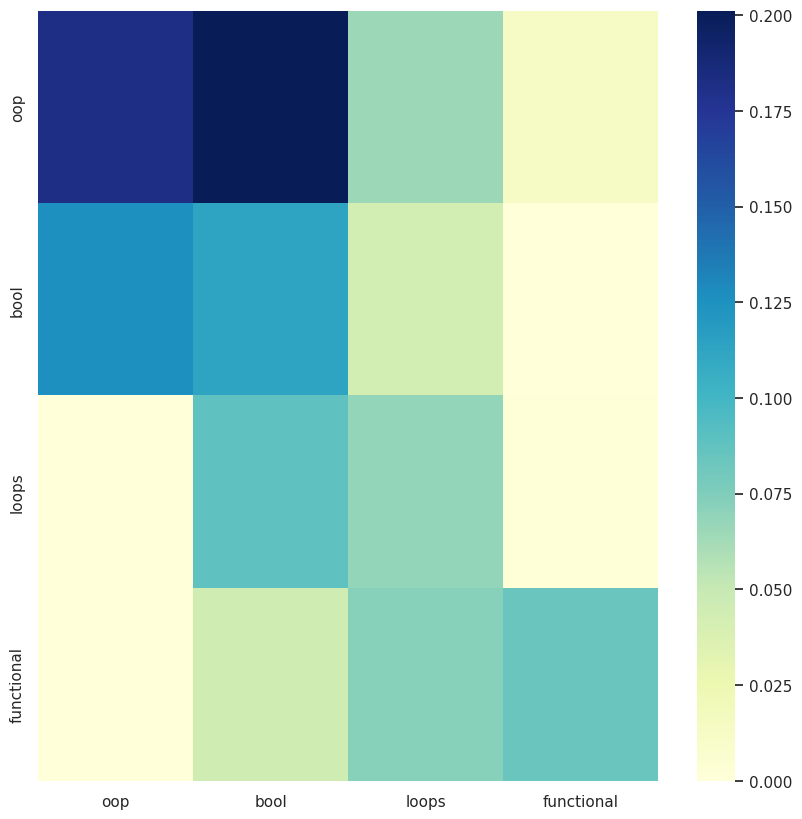

In [21]:
target_list = ['oop', 'bool', 'loops', 'functional']
rational_list = ['oop', 'bool', 'loops', 'functional']
print_heatmap(experients_global_results, target_list, rational_list)